### Import relevant libraries

In [119]:
import pandas as pd
import numpy as np
import os
from datetime import timedelta
pd.options.display.max_rows = 10
pd.options.display.max_columns = 100

### Read input files

In [120]:
patient_profile = pd.read_csv('Train/Patient_Profile.csv')
camp_detail = pd.read_csv('Train/Health_Camp_Detail.csv')
first_camp_attended = pd.read_csv('Train/First_Health_Camp_Attended.csv')
second_camp_attended = pd.read_csv('Train/Second_Health_Camp_Attended.csv')
third_camp_attended = pd.read_csv('Train/Third_Health_Camp_Attended.csv')
train = pd.read_csv('Train/train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submmission.csv')

first_camp_attended= first_camp_attended.drop('Unnamed: 4',axis=1)

### Create response

In [121]:
# create response
favourable_response = (first_camp_attended[['Patient_ID','Health_Camp_ID']]
                       .append(second_camp_attended[['Patient_ID','Health_Camp_ID']])
                       .append(third_camp_attended.loc[third_camp_attended.Number_of_stall_visited > 0,['Patient_ID','Health_Camp_ID']])
                      )
favourable_response['response'] = 1

### Features

In [130]:
train['flag'] = 'train'
test['flag'] = 'test'
all_obs = train.append(test)

# join with patient profile, all patients in test and train have profiles
all_obs = all_obs.merge(patient_profile,on = 'Patient_ID',how = 'inner')

# join with camp_detail
all_obs = all_obs.merge(camp_detail, on= 'Health_Camp_ID',how = 'inner')

# add response
all_obs = all_obs.merge(favourable_response, on = ['Patient_ID','Health_Camp_ID'],how = 'left')
all_obs.loc[all_obs.response.isna(),'response'] = 0
all_obs.response = all_obs.response.astype('int')

# convert dates to proper format
all_obs.Registration_Date = pd.to_datetime(all_obs.Registration_Date,format ='%d-%b-%y')
all_obs.First_Interaction = pd.to_datetime(all_obs.First_Interaction,format ='%d-%b-%y')
all_obs.Camp_Start_Date = pd.to_datetime(all_obs.Camp_Start_Date,format ='%d-%b-%y')
all_obs.Camp_End_Date = pd.to_datetime(all_obs.Camp_End_Date,format ='%d-%b-%y')

all_obs['camp_duration'] = (all_obs.Camp_End_Date - all_obs.Camp_Start_Date).dt.days

all_obs.loc[all_obs.Registration_Date.isna(),'Registration_Date'] = (all_obs.Camp_Start_Date + 
                                                                     pd.to_timedelta(all_obs.camp_duration/2,unit = 'D'))

all_obs['registered_before_camp_start'] = (all_obs.Registration_Date< all_obs.Camp_Start_Date).astype('int')

all_obs['days_left_campEnd'] = (all_obs['Camp_End_Date'] - all_obs['Registration_Date']).dt.days
all_obs['point_in_camp'] = 1 - all_obs['days_left_campEnd']/ all_obs['camp_duration']

all_obs['Last_interaction'] = all_obs.groupby('Patient_ID')['Registration_Date'].shift()
all_obs.loc[all_obs['Last_interaction'].isna(),'Last_interaction'] = all_obs.First_Interaction

all_obs['days_since_last_interaction'] = (all_obs.Registration_Date - all_obs.Last_interaction).dt.days
all_obs['days_since_first_interaction'] = (all_obs.Registration_Date - all_obs.First_Interaction).dt.days



all_obs = all_obs.sort_values(['Patient_ID','Registration_Date'])

# #one hot encoding for categorical
all_obs = all_obs.join(pd.get_dummies(all_obs.Category1))
all_obs = all_obs.join(pd.get_dummies(all_obs.Category2))
# # all_obs = all_obs.join(pd.get_dummies(all_obs.Category3))

# # split date
all_obs['weekday']= all_obs.Registration_Date.dt.weekday
all_obs['year'] = all_obs.Registration_Date.dt.year
all_obs['month'] = all_obs.Registration_Date.dt.month

In [131]:
# first category camps patient history

first_camp_attended['prev_first_outcome'] = 1


all_obs = all_obs.merge(first_camp_attended, on  = ['Patient_ID', 'Health_Camp_ID'],how = 'left')

all_obs.loc[all_obs.prev_first_outcome.isna(),'prev_first_outcome'] = 0
all_obs.loc[all_obs.Donation.isna(),'Donation'] = 0
all_obs.loc[all_obs.Health_Score.isna(),'Health_Score'] = 0

all_obs['prev_first_outcome']= all_obs.groupby(['Patient_ID'])['prev_first_outcome'].cumsum() - all_obs.prev_first_outcome
all_obs['prev_first_count'] = all_obs.groupby(['Patient_ID'])['First'].cumsum() - all_obs.First
all_obs['prev_donation'] = all_obs.groupby(['Patient_ID'])['Donation'].cumsum() - all_obs.Donation
all_obs['prev_first_score_mean'] = (all_obs.groupby(['Patient_ID'])['Health_Score'].cumsum() - all_obs.Health_Score)/ all_obs['prev_first_count']
all_obs.loc[all_obs['prev_first_score_mean'].isna(),'prev_first_score_mean'] = 0

In [132]:
# Second category camps patient history

second_camp_attended['prev_second_outcome'] = 1

all_obs = all_obs.merge(second_camp_attended, on  = ['Patient_ID', 'Health_Camp_ID'],how = 'left')

all_obs.loc[all_obs.prev_second_outcome.isna(),'prev_second_outcome'] = 0
all_obs.loc[all_obs['Health Score'].isna(),'Health Score'] = 0

all_obs['prev_second_outcome']= all_obs.groupby(['Patient_ID'])['prev_second_outcome'].cumsum() - all_obs.prev_second_outcome
all_obs['prev_second_count'] = all_obs.groupby(['Patient_ID'])['Second'].cumsum() - all_obs.Second
all_obs['prev_second_score_mean'] = (all_obs.groupby(['Patient_ID'])['Health Score'].cumsum() - all_obs['Health Score'])/ all_obs['prev_second_count']
all_obs.loc[all_obs['prev_second_score_mean'].isna(),'prev_second_score_mean'] = 0


In [133]:
# Second category camps patient history

third_camp_attended['prev_third_outcome']  =1
third_camp_attended.loc[third_camp_attended.Number_of_stall_visited == 0,'prev_third_outcome'] = 0

all_obs = all_obs.merge(third_camp_attended, on  = ['Patient_ID', 'Health_Camp_ID'],how = 'left')

all_obs.loc[all_obs.prev_third_outcome.isna(),'prev_third_outcome'] = 0
all_obs.loc[all_obs['Number_of_stall_visited'].isna(),'Number_of_stall_visited'] = 0

all_obs['prev_third_outcome']= all_obs.groupby(['Patient_ID'])['prev_third_outcome'].cumsum() - all_obs.prev_third_outcome
all_obs['prev_third_count'] = all_obs.groupby(['Patient_ID'])['Third'].cumsum() - all_obs.Third
all_obs['prev_third_stalls_mean'] = (all_obs.groupby(['Patient_ID'])['Number_of_stall_visited'].cumsum() - all_obs['Number_of_stall_visited'])/ all_obs['prev_third_count']
all_obs.loc[all_obs['prev_third_stalls_mean'].isna(),'prev_third_stalls_mean'] = 0


In [134]:
all_obs['prev_count'] = all_obs.prev_first_count+all_obs.prev_second_count+all_obs.prev_third_count

all_obs['prev_outcome'] = (all_obs.prev_first_outcome+all_obs.prev_second_outcome+all_obs.prev_third_outcome )/ all_obs['prev_count']

all_obs.loc[all_obs['prev_outcome'].isna(),'prev_outcome'] = 0


In [135]:
all_obs['prev_var1'] = (all_obs.groupby('Patient_ID')['Var1'].cumsum() - all_obs['Var1'])/ all_obs['prev_count']
all_obs['prev_var2'] = (all_obs.groupby('Patient_ID')['Var2'].cumsum() - all_obs['Var2'])/ all_obs['prev_count']
all_obs['prev_var3'] = (all_obs.groupby('Patient_ID')['Var3'].cumsum() - all_obs['Var3'])/ all_obs['prev_count']
all_obs['prev_var4'] = (all_obs.groupby('Patient_ID')['Var4'].cumsum() - all_obs['Var4'])/ all_obs['prev_count']
all_obs['prev_var5'] = (all_obs.groupby('Patient_ID')['Var5'].cumsum() - all_obs['Var5'])/ all_obs['prev_count']

all_obs.loc[all_obs.prev_var1.isna(),'prev_var1'] = 0 
all_obs.loc[all_obs.prev_var2.isna(),'prev_var2'] = 0 
all_obs.loc[all_obs.prev_var3.isna(),'prev_var3'] = 0 
all_obs.loc[all_obs.prev_var4.isna(),'prev_var4'] = 0 
all_obs.loc[all_obs.prev_var5.isna(),'prev_var5'] = 0 


In [136]:

all_obs.loc[all_obs.Education_Score == 'None','Education_Score'] = None
all_obs.Education_Score = all_obs.Education_Score.astype('float')

all_obs.loc[all_obs.Age == 'None','Age'] = None
all_obs.Age = all_obs.Age.astype('float')

all_obs.loc[all_obs.Income == 'None','Income'] = None
all_obs.Income = all_obs.Income.astype('float')


In [137]:
all_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110527 entries, 0 to 110526
Data columns (total 67 columns):
Patient_ID                      110527 non-null int64
Health_Camp_ID                  110527 non-null int64
Registration_Date               110527 non-null datetime64[ns]
Var1                            110527 non-null int64
Var2                            110527 non-null int64
Var3                            110527 non-null int64
Var4                            110527 non-null int64
Var5                            110527 non-null int64
flag                            110527 non-null object
Online_Follower                 110527 non-null int64
LinkedIn_Shared                 110527 non-null int64
Twitter_Shared                  110527 non-null int64
Facebook_Shared                 110527 non-null int64
Income                          29185 non-null float64
Education_Score                 12360 non-null float64
Age                             32602 non-null float64
First_Intera

In [141]:
exclusions = (['Patient_ID','Health_Camp_ID','Registration_Date','flag','First_Interaction',
               'City_Type','Employer_Category','Camp_Start_Date','Camp_End_Date', 'Category1',
               'Category2',
#                'Income','Age','Education_Score',
               'Donation','Health_Score',
               'Health Score','Number_of_stall_visited','Last_Stall_Visited_Number',
               'Last_interaction',
               'response'])

response = 'response'

train_set = all_obs.loc[all_obs.flag == 'train',:]

test_set = all_obs.loc[all_obs.flag == 'test',:]

In [142]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score

In [150]:
#split by date insted of random

# X_train, X_validate, Y_train, Y_validate = train_test_split(train_set.drop( exclusions,axis=1),
#                                                     train_set['response'], test_size=0.2,random_state = 1)

X_train = train_set.loc[train_set.Camp_Start_Date < '2005-07-01',:].drop(exclusions,axis =1)
Y_train = train_set.loc[train_set.Camp_Start_Date < '2005-07-01','response']
X_validate = train_set.loc[train_set.Camp_Start_Date > '2005-07-01',:].drop(exclusions,axis =1)
Y_validate = train_set.loc[train_set.Camp_Start_Date > '2005-07-01','response']



D_train = xgb.DMatrix(X_train, label=Y_train)
D_validate = xgb.DMatrix(X_validate, label=Y_validate)
D_test = xgb.DMatrix(test_set.drop( exclusions,axis=1))

param = {
    'eta': 0.01, 
    'max_depth': 6,  
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
    } 

steps = 1000

baseline_model = xgb.train(param, D_train, steps,early_stopping_rounds = 50, verbose_eval = 50,
                           evals = [(D_train,'train'),(D_validate,'eval')])

preds = baseline_model.predict(D_validate)

print(roc_auc_score(Y_validate,preds))


[0]	train-logloss:0.68771	eval-logloss:0.68885
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[50]	train-logloss:0.50985	eval-logloss:0.55709
[100]	train-logloss:0.42760	eval-logloss:0.50133
[150]	train-logloss:0.38556	eval-logloss:0.47600
[200]	train-logloss:0.36224	eval-logloss:0.46534
[250]	train-logloss:0.34759	eval-logloss:0.46176
[300]	train-logloss:0.33727	eval-logloss:0.46114
[350]	train-logloss:0.32969	eval-logloss:0.46141
Stopping. Best iteration:
[315]	train-logloss:0.33479	eval-logloss:0.46105

0.8423765977849924


In [151]:
cv = xgb.cv(param, D_train, 1000,early_stopping_rounds = 50, verbose_eval = 50,nfold = 5)

[0]	train-logloss:0.68769+0.00001	test-logloss:0.68776+0.00005
[50]	train-logloss:0.50938+0.00062	test-logloss:0.51300+0.00145
[100]	train-logloss:0.42683+0.00064	test-logloss:0.43361+0.00228
[150]	train-logloss:0.38423+0.00064	test-logloss:0.39401+0.00275
[200]	train-logloss:0.36049+0.00065	test-logloss:0.37302+0.00313
[250]	train-logloss:0.34549+0.00064	test-logloss:0.36071+0.00340
[300]	train-logloss:0.33509+0.00080	test-logloss:0.35297+0.00341
[350]	train-logloss:0.32709+0.00091	test-logloss:0.34754+0.00345
[400]	train-logloss:0.32072+0.00094	test-logloss:0.34369+0.00358
[450]	train-logloss:0.31579+0.00103	test-logloss:0.34108+0.00377
[500]	train-logloss:0.31171+0.00110	test-logloss:0.33915+0.00387
[550]	train-logloss:0.30828+0.00107	test-logloss:0.33772+0.00395
[600]	train-logloss:0.30521+0.00113	test-logloss:0.33650+0.00398
[650]	train-logloss:0.30243+0.00113	test-logloss:0.33544+0.00406
[700]	train-logloss:0.29972+0.00111	test-logloss:0.33445+0.00414
[750]	train-logloss:0.29744+

In [152]:
cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.687690,0.000011,0.687761,0.000049
1,0.682364,0.000068,0.682508,0.000106
2,0.677135,0.000094,0.677361,0.000165
3,0.672131,0.000155,0.672420,0.000292
4,0.667103,0.000128,0.667470,0.000302
...,...,...,...,...
995,0.286917,0.000917,0.330500,0.004386
996,0.286872,0.000913,0.330486,0.004390
997,0.286834,0.000912,0.330477,0.004395
998,0.286797,0.000907,0.330468,0.004396


# Diagnostics

### Feature Importance

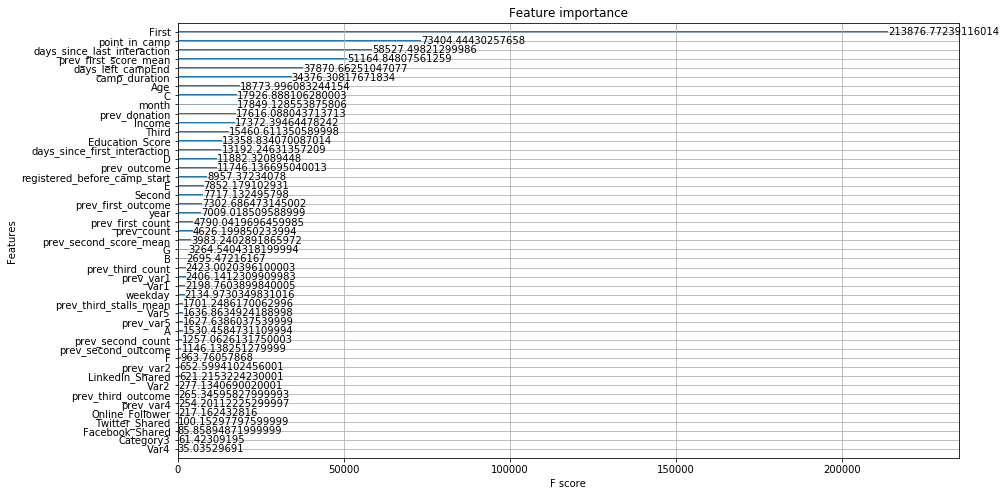

In [154]:
#feature importance
plt.rcParams["figure.figsize"] = (14, 8)
xgb.plot_importance(baseline_model,importance_type = 'total_gain')

In [155]:
gains = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'gain'),'index',columns = ['gain'])
weight = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'weight'),'index',columns = ['weight'])
cover = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'cover'),'index',columns = ['cover'])
total_gains = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'total_gain'),'index',columns = ['total_gains'])
total_cover = pd.DataFrame.from_dict(baseline_model.get_score(importance_type= 'total_cover'),'index',columns = ['total_cover'])


pd.options.display.max_rows = 100
pd.concat([gains, weight,cover, total_gains,total_cover], axis=1).sort_values('weight',ascending = False)

,gain,weight,cover,total_gains,total_cover
days_since_last_interaction,19.373551,3021,577.101320,58527.498213,1.743423e+06
days_left_campEnd,18.286172,2071,471.410060,37870.662510,9.762902e+05
point_in_camp,35.702551,2056,583.362094,73404.444303,1.199392e+06
days_since_first_interaction,8.707753,1515,175.373956,13192.246314,2.656915e+05
camp_duration,24.056199,1429,537.172560,34376.308177,7.676196e+05
Age,15.829676,1186,445.350532,18773.996083,5.281857e+05
prev_first_score_mean,48.589599,1053,990.463107,51164.848076,1.042958e+06
Education_Score,13.071266,1022,487.365949,13358.834070,4.980880e+05
month,18.176302,982,785.778003,17849.128554,7.716340e+05
prev_outcome,16.732388,702,406.188715,11746.136695,2.851445e+05


### Predicted vs Observed

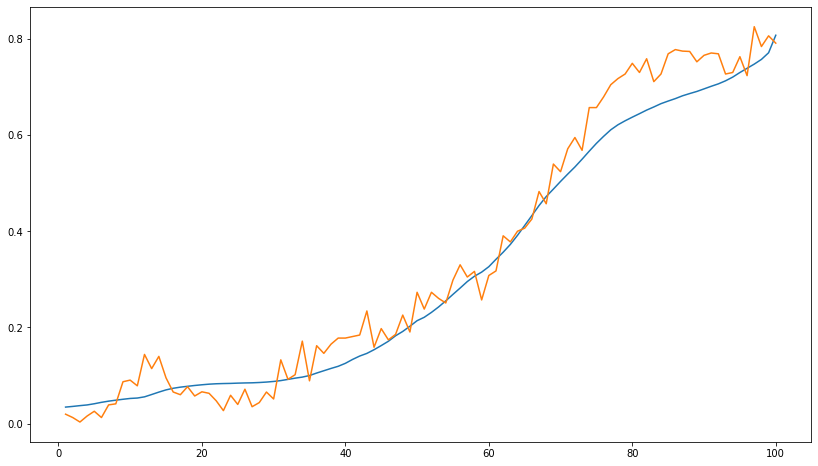

In [156]:
#pvo
def pvo(obs, pred):
    pvo = pd.DataFrame(list(zip(obs,pred)),columns =['observed','predicted']).reset_index()
    pvo['percentile'] = np.ceil(100 * pvo.predicted.rank(ascending =True)/len(pvo.index))
    pvo = pvo.groupby(['percentile'])['observed','predicted'].mean().reset_index()
    plt.plot(pvo.percentile,pvo.predicted, label = 'Predicted')
    plt.plot(pvo.percentile,pvo.observed, label = 'Observed')

#pdp

pvo(Y_validate,preds)

### ROC and AUC

AUC = 0.8423765977849924


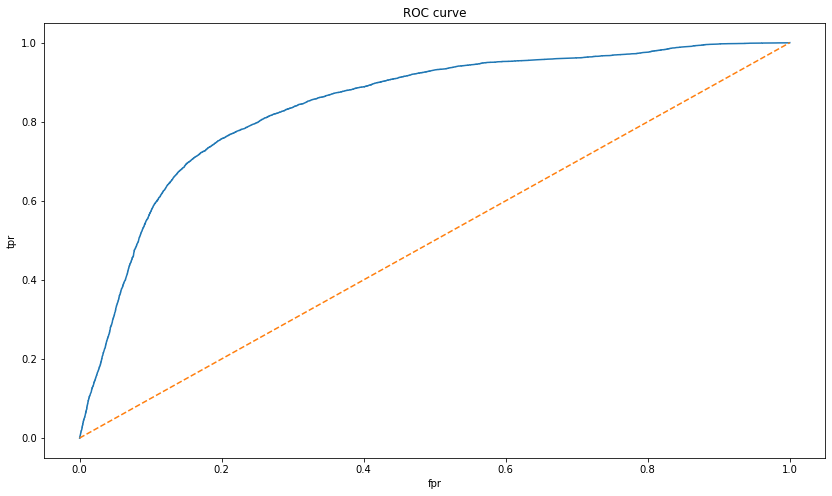

In [157]:
fpr, tpr, thresholds = roc_curve(Y_validate,preds)
print("AUC = " + str(roc_auc_score(Y_validate,preds)))
plt.plot(fpr,tpr, label = 'model')
plt.plot([0,1],[0,1], label = 'random',linestyle='--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

In [148]:
# from sklearn.inspection import plot_partial_dependence
# plot_partial_dependence(baseline_model,X_train,features)

### Generate submission 

In [149]:
#retrain on whole data
X_train = train_set.drop(exclusions,axis =1)
Y_train = train_set[['response']]



D_train = xgb.DMatrix(X_train, label=Y_train)
D_test = xgb.DMatrix(test_set.drop( exclusions,axis=1))

param = {
    'eta': 0.02, 
    'max_depth': 5,  
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'objective': 'binary:logistic',
    'eval_metric':'logloss'
    } 

steps = 175

model = xgb.train(param, D_train, steps)


#score test
submission = test_set.loc[:,['Patient_ID','Health_Camp_ID']]
submission['Outcome'] = model.predict(D_test)

submission = sample_sub[['Patient_ID','Health_Camp_ID']].merge(submission,on = ['Patient_ID','Health_Camp_ID'])
submission.to_csv('submission6.csv',index =False)